## Quiz 3: KNN

1. Generate a sample using make_blobs from sklearn.datasets with n_samples = 200, center = 3, cluster_std = 1.0 and plot it using a scatter plot where different colours indicate different clusters (1 point)

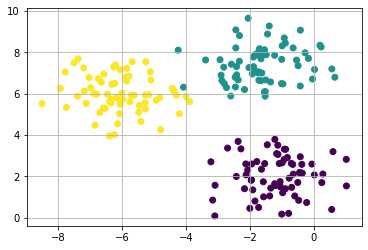

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, centers=3, cluster_std=1.0)
plt.grid()
plt.scatter(X[:, 0], X[:, 1], c=y)

2. In the KNN lecture notes, it says that there are many methods to calculate the distance between points. So far we have studied euclidean distance, so in this quiz we would like you to explore other distance measurement methods. Please implement **at least one other distance measurement method** and include it in your KNN class which you have implemented in your KNN assignment. (3 points)

Note: Your class should allow users to choose their own distance measurement method, and should raise ValueError when undefined methods was given as input

Hint: https://machinelearningmastery.com/distance-measures-for-machine-learning/

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train[y_train==0] = -1
y_test[y_test==0] = -1

In [14]:
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
class SVMModel:
    
    def linear_kernel(self,x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self,x, y, p=2):
        return (1 + np.dot(x, y)) ** p

    def gaussian_kernel(self,x, y, sigma=0.9999):
        return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

    def fit(self, X, y, kernel, C):
        n_samples, n_features = X.shape

        # Gram matrix
        # initialize kernel matrix    
        K = np.zeros((n_samples, n_samples))
        # Kernel matrix

        for i in range(n_samples):
            for j in range(n_samples):
                if kernel == 'linear_kernel':
                    K[i,j] = self.linear_kernel(X[i], X[j])
                elif kernel == 'polynomial_kernel':
                    K[i,j] = self.polynomial_kernel(X[i], X[j])
                else:
                    K[i,j] = self.gaussian_kernel(X[i], X[j])


        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv_idx = a > 1e-5
        ind = np.arange(len(a))[sv_idx]
        a = a[sv_idx]    
        sv = X[sv_idx]
        sv_y = y[sv_idx]
        print("%d support vectors out of %d points" % (len(a), n_samples))

        # Intercept
        b = 0
        for n in range(len(a)): #b = y - wTx
            b += sv_y[n]
            b -= np.sum(a * sv_y * K[ind[n],sv_idx])
        b /= len(a)

        # Weight vector
        if kernel == 'linear_kernel':
            w = np.zeros(n_features)
            for n in range(len(a)):
                w += a[n] * sv_y[n] * sv[n]
        else:
            w = None
        return sv, sv_y, a, w, b

    def project(self,X, kernel,sv, sv_y, a, w, b):
        if w is not None:  #this is linear
            return np.dot(X, w) + b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a_val, sv_y_val, sv_val in zip(a, sv_y, sv):
                    if kernel == 'polynomial_kernel':
                        s += a_val * sv_y_val * self.polynomial_kernel(X[i], sv_val)
                    else:
                        s += a_val * sv_y_val * self.gaussian_kernel(X[i], sv_val)
                y_predict[i] = s
            return y_predict + b

    def predict(self,X, kernel, sv, sv_y, a, w, b):
        return np.sign(self.project(X, kernel,sv, sv_y, a, w, b))
    
    def plot_contour(self,X1_train, X2_train, kernel, sv, sv_y, a, w, b):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(sv[:,0], sv[:,1], s=100, c="g")
        # here we choose the range between -7 and 7 as we have choosen
        # the mean to be between -4 and 4 while generating data with the variance of 0.8
        X1, X2 = np.meshgrid(np.linspace(-7,7,50), np.linspace(-7,7,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = self.project(X, kernel,sv, sv_y, a, w, b).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

In [15]:
SVM = SVMModel()

kernel = 'gaussian_kernel'

sv, sv_y, a, w, b = SVM.fit(X_train,y_train,kernel=kernel,C=None)

y_pred = SVM.predict(X_test,kernel,sv,sv_y,a,w,b).astype(int)

print("y_test:",y_test.astype(int))
print("y_pred:",y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

TypeError: 'A' must be a 'd' matrix with 140 columns

3. Perform cross validation to find the best value of k and perform classification using **all** the distance measurement methods (also raise ValueError) you have implemented. (3 points)

4. **Justify and Discuss** your results i.e. distant measurement methods, value of k, etc. (2 points)